<a href="https://colab.research.google.com/github/Nancyp1997/ComputerVisionProjects/blob/master/CrowdCounting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imnancy","key":"8923d254f93eb0d13b11f8c70a3f9faa"}'}

In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:

! kaggle datasets download -d fmena14/crowd-counting

100% 1.17G/1.18G [00:10<00:00, 102MB/s]
100% 1.18G/1.18G [00:11<00:00, 115MB/s]


In [8]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
from keras.optimizers import RMSprop, Adam
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

In [9]:
! unzip crowd-counting.zip

Archive:  crowd-counting.zip
  inflating: frames/frames/seq_000001.jpg  
  inflating: frames/frames/seq_000002.jpg  
  inflating: frames/frames/seq_000003.jpg  
  inflating: frames/frames/seq_000004.jpg  
  inflating: frames/frames/seq_000005.jpg  
  inflating: frames/frames/seq_000006.jpg  
  inflating: frames/frames/seq_000007.jpg  
  inflating: frames/frames/seq_000008.jpg  
  inflating: frames/frames/seq_000009.jpg  
  inflating: frames/frames/seq_000010.jpg  
  inflating: frames/frames/seq_000011.jpg  
  inflating: frames/frames/seq_000012.jpg  
  inflating: frames/frames/seq_000013.jpg  
  inflating: frames/frames/seq_000014.jpg  
  inflating: frames/frames/seq_000015.jpg  
  inflating: frames/frames/seq_000016.jpg  
  inflating: frames/frames/seq_000017.jpg  
  inflating: frames/frames/seq_000018.jpg  
  inflating: frames/frames/seq_000019.jpg  
  inflating: frames/frames/seq_000020.jpg  
  inflating: frames/frames/seq_000021.jpg  
  inflating: frames/frames/seq_000022.jpg  
  i

In [10]:
df = pd.read_csv('/content/labels.csv')
df.head()

,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


In [11]:
#Adding new column image_name in dataframe
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [12]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


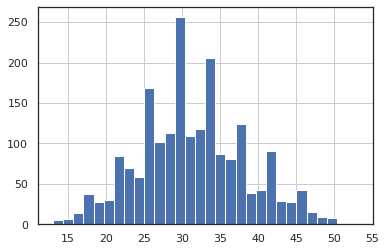

In [13]:
df['count'].hist(bins=30)

In [14]:
size = 224
batch_size = 64
import keras
datagen = ImageDataGenerator(
    rescale=1./255,  
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,  
    horizontal_flip=False,  
    vertical_flip=False,
    validation_split=0.2, 
    preprocessing_function=resnet50.preprocess_input,  
)

In [15]:
flow_params = dict(
    dataframe = df,
    directory = 'frames/frames',
    x_col = "image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode  = 'rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

train_generator = datagen.flow_from_dataframe(
    subset="training",
    **flow_params
)

validation_generator = datagen.flow_from_dataframe(
    subset="validation",
    **flow_params
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

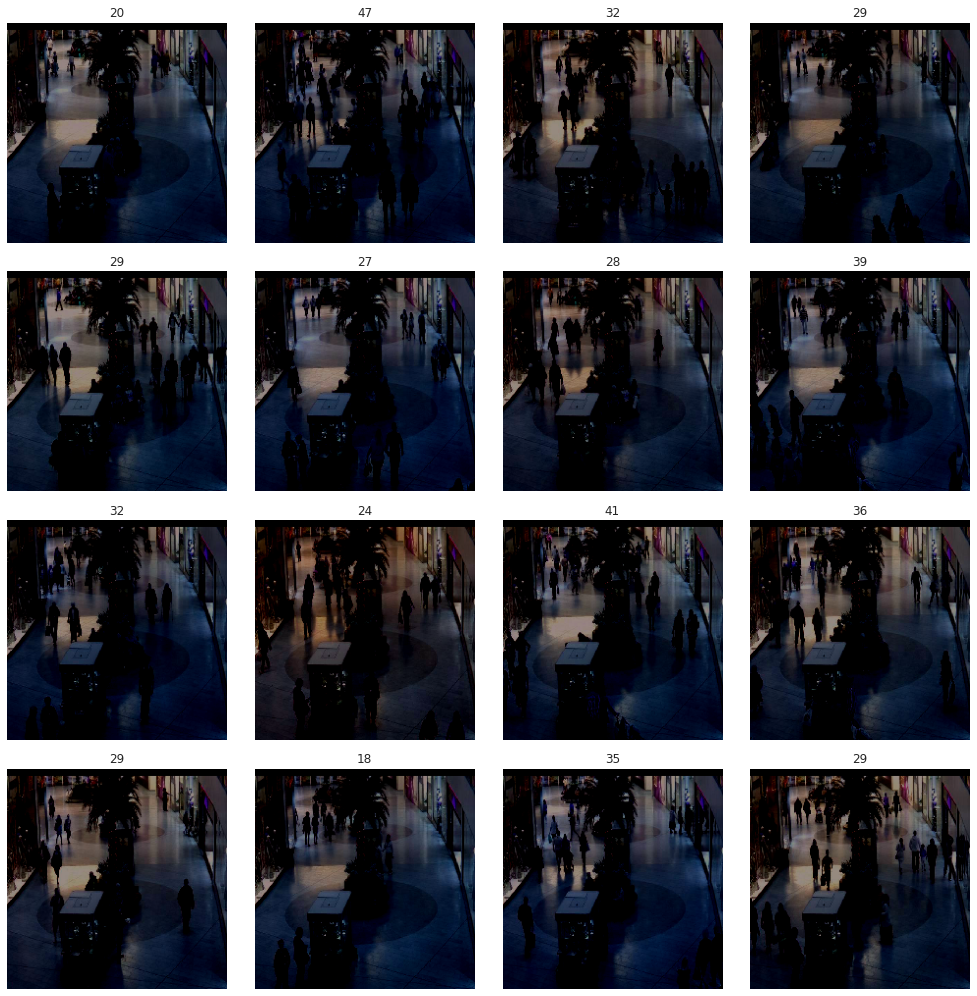

In [16]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
  ax = axes[i]
  ax.imshow(batch[0][i])
  ax.axis('off')
  ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

In [17]:
#MODEL
base_model = resnet50.ResNet50(weights='imagenet',include_top=False, input_shape=(size,size,3), pooling='avg',)

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
x = base_model.output
x = Dense(1024,activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
k=-7
for layer in model.layers[:k]:
  layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
  print(layer.name)
  layer.trainable=True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [22]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss="mean_squared_error", metrics=['mean_absolute_error','mean_squared_error'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error',patience=3, verbose=1,factor=0.2,min_lr=0.000001)

In [23]:
# Fit the model
history = model.fit_generator(
    generator=train_generator,
    epochs=10,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=validation_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
25/25 - 295s - loss: 120.8222 - mean_absolute_error: 7.9194 - mean_squared_error: 120.8222 - val_loss: 2510.9456 - val_mean_absolute_error: 49.7945 - val_mean_squared_error: 2510.9456
Epoch 2/10
25/25 - 295s - loss: 33.6621 - mean_absolute_error: 4.6659 - mean_squared_error: 33.6621 - val_loss: 1023.3627 - val_mean_absolute_error: 31.5489 - val_mean_squared_error: 1023.3627
Epoch 3/10
25/25 - 293s - loss: 29.8243 - mean_absolute_error: 4.4151 - mean_squared_error: 29.8243 - val_loss: 454.4125 - val_mean_absolute_error: 20.6779 - val_mean_squared_error: 454.4125
Epoch 4/10
25/25 - 294s - loss: 30.0508 - mean_absolute_error: 4.3945 - mean_squared_error: 30.0508 - val_loss: 292.7236 - val_mean_absolute_error: 16.3286 - val_mean_squared_error: 292.7236
Epoch 5/10
25/25 - 293s - loss: 26.8207 - mean_absolute_error: 4.1718 - mean_squared_error: 26.8207 - val_loss: 188.3829 - val_mean_absolute_error: 12.795

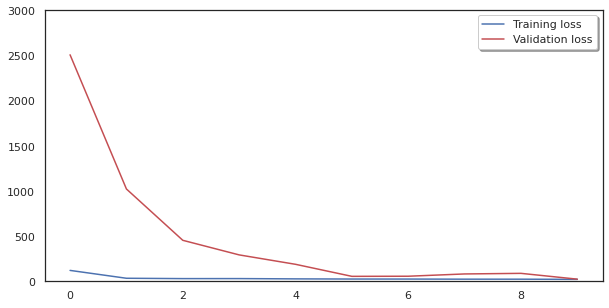

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best',shadow=True)

In [25]:
validation_generator.reset()
all_labels=[]
all_pred=[]
for i in range(len(validation_generator)):
  x = next(validation_generator)
  pred_i = model.predict(x[0])[:,0]
  labels_i = x[1]
  all_labels.append(labels_i)
  all_pred.append(pred_i)
cat_labels = np.concatenate(all_labels)
cat_pred = np.concatenate(all_pred)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


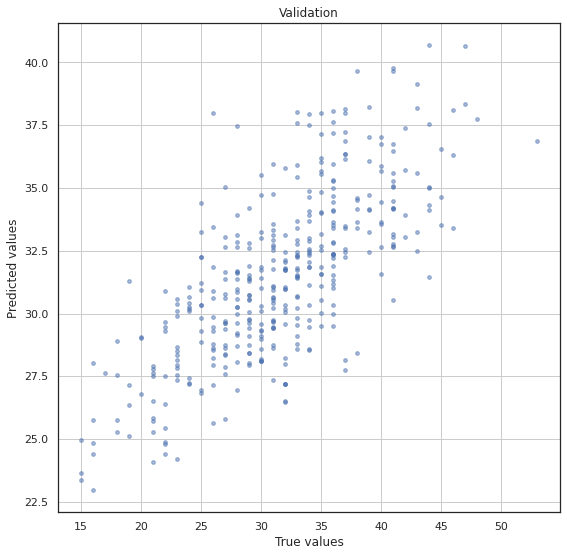

In [29]:
df_predictions = pd.DataFrame({'True values': cat_labels, 'Predicted values': cat_pred})
ax = df_predictions.plot.scatter('True values','Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
#add_one_to_one_correlation_line(ax)
ax.set_title('Validation')
plt.show()

In [31]:
mse = mean_squared_error(*df_predictions.T.values)
pearson_r = sc.stats.pearsonr(*df_predictions.T.values)[0]

print(mse)
print(pearson_r)

23.70253660828372
0.7298815649976464
